## Imports

In [81]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [82]:
from icnnet import ICNNet
from mydataset import MyDataset
import toy_data_dataloader_gaussian

from gaussian_transport import compute_A, compute_w, gaussian_transport

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy data


In [84]:
dataloader, locs, scales = toy_data_dataloader_gaussian.get_dataloader(N = 500, batch_size = 100, r = 250)

In [85]:
# cur_X = dataloader.dataset.X
# dataloader.dataset.X = dataloader.dataset.Y
# dataloader.dataset.Y = cur_X
# C = dataloader.dataset.C

In [86]:
cov1 = np.eye(2)
cov2 = 9* np.eye(2)
m1 = np.zeros(2)
m2 = 4*np.ones(2)

A = compute_A(cov1, cov2)
w = compute_w(m1, m2, A)

In [87]:
x = list()
c = list()
y_transport = list()
for x_batch, c_batch, y_batch in dataloader:
    x.append(x_batch)
    c.append(c_batch)
    results = []
    for i in range(x_batch.shape[0]):
        for j in range(x_batch.shape[1]):
            result = gaussian_transport(x_batch[i, j], A, w)
            results.append(result)
    y_transport.append(torch.stack(results).reshape((x_batch.shape[0], x_batch.shape[1],1)))
print()
X = torch.cat(x, dim = 0)
C = torch.cat(c, dim = 0)
Y = torch.cat(y_transport, dim = 0).float()


gaussian_dataset = MyDataset(X, C, Y)
gaussian_dataloader = DataLoader(gaussian_dataset, batch_size=100, shuffle=True)



/users/eleves-b/2021/valentin.dorseuil/Desktop/CondOT/gaussian_transport.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u)


In [88]:
print(X.shape, C.shape, Y.shape)
print(dataloader.dataset.X.shape, dataloader.dataset.C.shape, dataloader.dataset.Y.shape)

torch.Size([500, 250, 2]) torch.Size([500, 250, 2]) torch.Size([500, 250, 1])
torch.Size([500, 250, 2]) torch.Size([500, 250, 2]) torch.Size([500, 250, 2])


## Training

### PICNN training

In [89]:
epochs = 100

# Initialize the model
input_size = 2
output_size = 1

model = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in gaussian_dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)

    # for name, parameter in model.named_parameters():
    #     if parameter.requires_grad and parameter.grad is not None:
    #         grad_norm = parameter.grad.norm().item()
    #         print(f"Gradient norm for {name}: {grad_norm}")
    
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

Epoch 1/100 Loss: 76.7206802368164
Epoch 2/100 Loss: 56.58172607421875
Epoch 3/100 Loss: 52.268310546875
Epoch 4/100 Loss: 41.23411560058594
Epoch 5/100 Loss: 39.025543212890625
Epoch 6/100 Loss: 29.15311050415039
Epoch 7/100 Loss: 24.989782333374023
Epoch 8/100 Loss: 24.084102630615234
Epoch 9/100 Loss: 22.192184448242188
Epoch 10/100 Loss: 19.951446533203125
Epoch 11/100 Loss: 17.41982078552246
Epoch 12/100 Loss: 16.75741958618164
Epoch 13/100 Loss: 19.60989761352539
Epoch 14/100 Loss: 16.227916717529297
Epoch 15/100 Loss: 17.229936599731445
Epoch 16/100 Loss: 15.430060386657715
Epoch 17/100 Loss: 14.009434700012207
Epoch 18/100 Loss: 14.882116317749023
Epoch 19/100 Loss: 13.901847839355469
Epoch 20/100 Loss: 13.008819580078125
Epoch 21/100 Loss: 12.042244911193848
Epoch 22/100 Loss: 11.057687759399414
Epoch 23/100 Loss: 11.667607307434082
Epoch 24/100 Loss: 10.538055419921875
Epoch 25/100 Loss: 9.004267692565918
Epoch 26/100 Loss: 8.886458396911621
Epoch 27/100 Loss: 6.8305683135986

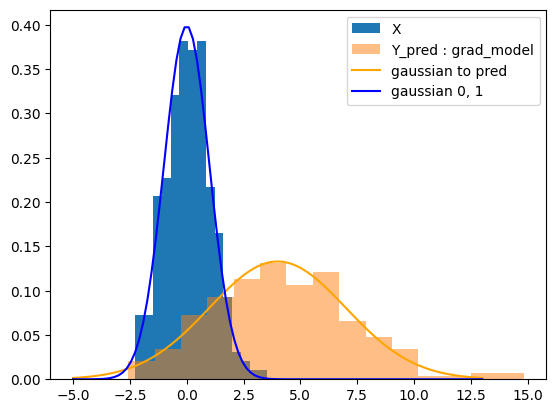

In [93]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C

test = 4

x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]

mu = 4
std_dev = 3

y_i.requires_grad_(True)
x_i.requires_grad_(True)
#c_i.requires_grad_(True)    



values = np.linspace(mu - 3*std_dev, mu + 3*std_dev, 100)

output_model = model(x_i, c_i)

grad_model = torch.autograd.grad(outputs=output_model, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
#plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model[:, 0].detach().numpy(),  bins=15, label = 'Y_pred : grad_model', density = True, alpha = 0.5)
plt.plot(values, stats.norm.pdf(values, mu, std_dev), label = "gaussian to pred", color = 'orange')
plt.plot(values, stats.norm.pdf(values, 0, 1), label = "gaussian 0, 1", color = 'blue')
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)

plt.legend()

plt.show()

In [121]:
import numpy as np
import ot

# Define two discrete distributions
# They should be 1D arrays that sum  1
r = 250

a = X[test, :, 0].detach().numpy()
b = grad_model[:, 0].detach().numpy()

M = ot.dist(a.reshape((r,1)), b.reshape((r,1)))

print(M)
ot.emd2(X[test, :, 0], grad_model[:, 0], torch.tensor(M))



[[4.12270805e-04 3.04411049e-04 6.59349200e-04 ... 3.31101328e-04
  4.47318773e-04 4.41903336e-04]
 [6.17776671e-03 5.73680457e-03 7.05131562e-03 ... 5.85079752e-03
  6.31138543e-03 6.29099831e-03]
 [4.26144525e-03 4.64262580e-03 3.58877680e-03 ... 4.54114331e-03
  4.15177690e-03 4.16834187e-03]
 ...
 [4.30703070e-03 3.94018600e-03 5.04118670e-03 ... 4.03475342e-03
  4.41871723e-03 4.40166146e-03]
 [1.06519656e-04 5.57077619e-05 2.46307289e-04 ... 6.74463663e-05
  1.24686165e-04 1.21834804e-04]
 [8.51613586e-05 4.05924256e-05 2.13207764e-04 ... 5.06948163e-05
  1.01480458e-04 9.89096952e-05]]


/users/eleves-b/2021/valentin.dorseuil/Desktop/CondOT/condot/lib64/python3.9/site-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


tensor(0., grad_fn=<ValFunctionBackward>)

## __Makkuva__

In [74]:
# Initialize the model
input_size = 2
output_size = 1

ICNNf = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])
ICNNg = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Get the state dictionary from the trained model
state_dict = model.state_dict()

# Load the state dictionary into ICNNf and ICNNg
ICNNf.load_state_dict(state_dict)
ICNNg.load_state_dict(state_dict)

<All keys matched successfully>

In [75]:
epochs = 100
train_freq_g = 10


# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters(), lr = 0.0001)
optimizer_g = optim.Adam(ICNNg.parameters(), lr = 0.0001)

for epoch in range(epochs):
    for freq in range(train_freq_g) :
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_g = ICNNf(grad_g, c) - torch.sum(y * grad_g, dim=-1, keepdim=True)
            loss_g = loss_g.mean(dim=(1, 2)).mean()

            #print('min f(grad_g, c)', ICNNf(grad_g, c)[0][0])
            #print('max f(grad_g, c)', torch.sum(y * grad_g, dim=-1, keepdim=True)[0][0])

            loss_g.backward() # Backward pass
            optimizer_g.step() # Update the parameters

            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)
                    
            # for name, parameter in ICNNg.named_parameters():
            #     if parameter.requires_grad and parameter.grad is not None:
            #         grad_norm = parameter.grad.norm().item()
            #         print(f"Gradient norm for {name}: {grad_norm}")
                    
            #print(f"training g {freq+1}/{train_freq_g} loss_g: {loss_g.item()}")

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()

        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
    
        output_g = ICNNg(y, c)
        grad_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

        #print('ICNNf(grad_g, c)', ICNNf(grad_g, c))

        loss_f = ICNNf(x, c) - ICNNf(grad_g, c)
        #loss_f =  torch.mean(loss_f)
        loss_f =   torch.mean(loss_f) #page 24, f is updated by fixing g and maximizing (15) with a single iteration

        #print('max f(grad_g, c)', ICNNf(grad_g, c)[0][0])

        loss_f.backward() # Backward pass
        optimizer_f.step()
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

        # for name, parameter in ICNNf.named_parameters():
        #     if parameter.requires_grad and parameter.grad is not None:
        #         grad_norm = parameter.grad.norm().item()
        #         print(f"Gradient norm for {name}: {grad_norm}")
        
    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

Epoch 1/100 loss_g: -33.439674377441406, loss_f: -119.73507690429688
Epoch 2/100 loss_g: -313.8789978027344, loss_f: -420.6636657714844
Epoch 3/100 loss_g: -1870.95849609375, loss_f: -4881.11474609375
Epoch 4/100 loss_g: -4345.0859375, loss_f: -45919.0546875
Epoch 5/100 loss_g: -211.50486755371094, loss_f: -46669.06640625
Epoch 6/100 loss_g: 2065.364501953125, loss_f: -11265.875
Epoch 7/100 loss_g: 704.2401733398438, loss_f: -5839.37353515625
Epoch 8/100 loss_g: 1087.5882568359375, loss_f: -2999.222412109375
Epoch 9/100 loss_g: 384.5914306640625, loss_f: -600.5704956054688
Epoch 10/100 loss_g: 183.95849609375, loss_f: -513.0568237304688
Epoch 11/100 loss_g: 80.0401840209961, loss_f: -117.87085723876953
Epoch 12/100 loss_g: 36.85777282714844, loss_f: -84.5353012084961
Epoch 13/100 loss_g: 15.237702369689941, loss_f: -23.68413543701172
Epoch 14/100 loss_g: 5.428701400756836, loss_f: -10.059773445129395
Epoch 15/100 loss_g: 1.5882872343063354, loss_f: -2.0347282886505127
Epoch 16/100 loss

KeyboardInterrupt: 

In [28]:
filename_pth_f = 'ICNNf_TR.pth'
filename_pth_g = 'ICNNg_TR.pth'

torch.save(ICNNf.state_dict(), filename_pth_f)
torch.save(ICNNg.state_dict(), filename_pth_g)

In [ ]:
ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,64,output_size])
ICNNf.load_state_dict(torch.load(filename_pth_f))

ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size,64,64,64,64,input_size], context_layer_sizes=[output_size,64,64,64,64,input_size])
ICNNg.load_state_dict(torch.load(filename_pth_g))

<All keys matched successfully>

tensor([[4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0000, 0.7759],
        [4.0

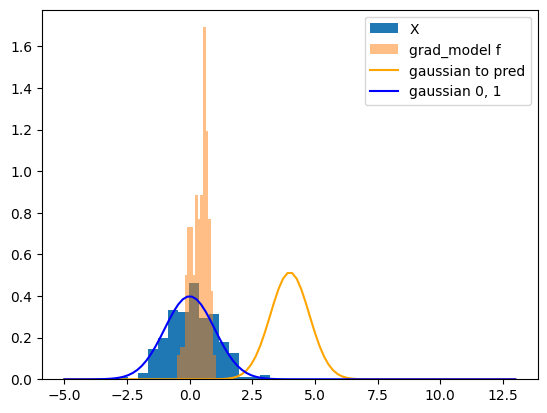

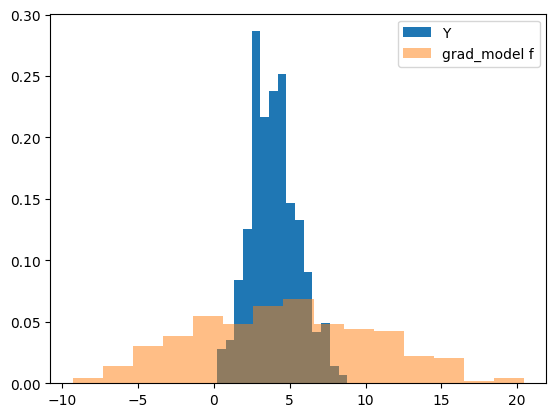

tensor([[-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4.5665],
        [-6.0000,  4

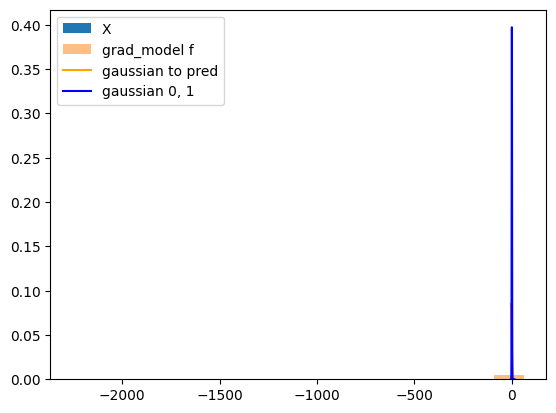

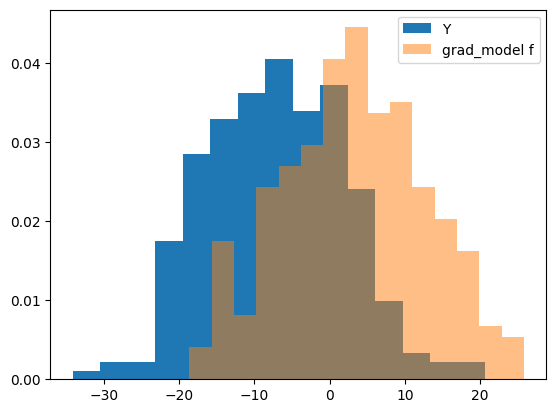

tensor([[-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2.2063],
        [-1.0000,  2

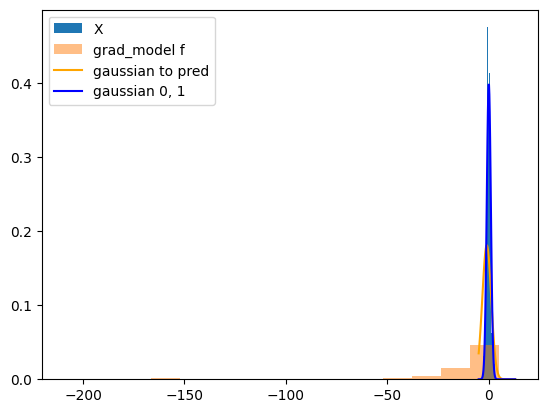

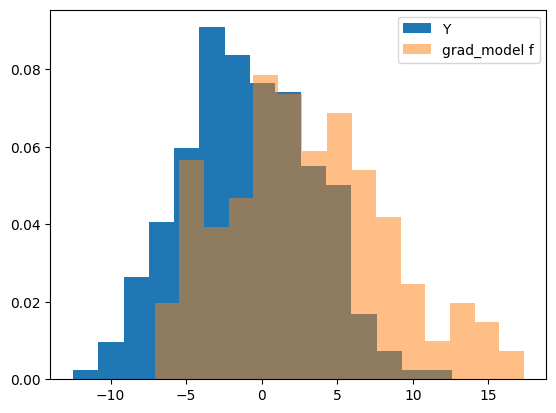

tensor([[-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0.4308],
        [-4.0000,  0

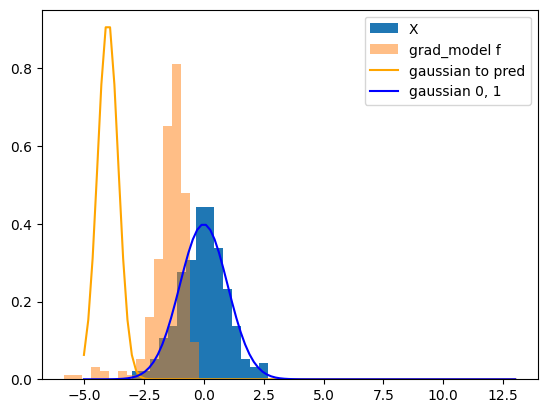

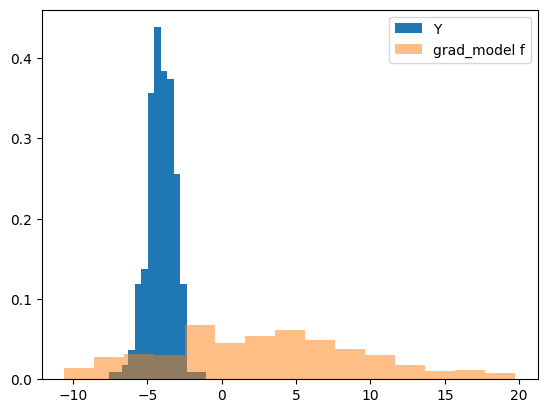

tensor([[1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0000, 1.9118],
        [1.0

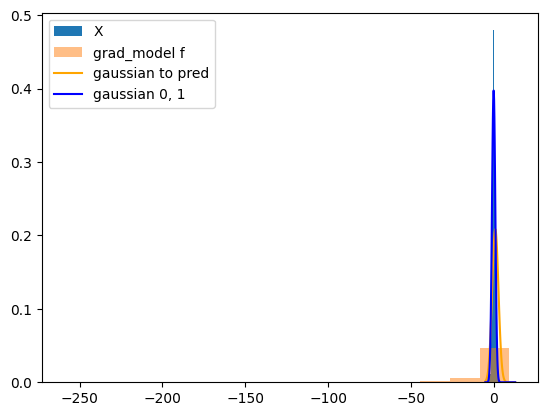

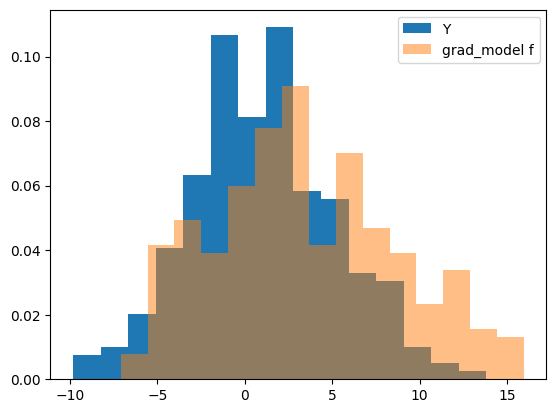

tensor([[10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0.8989],
        [10.0000,  0

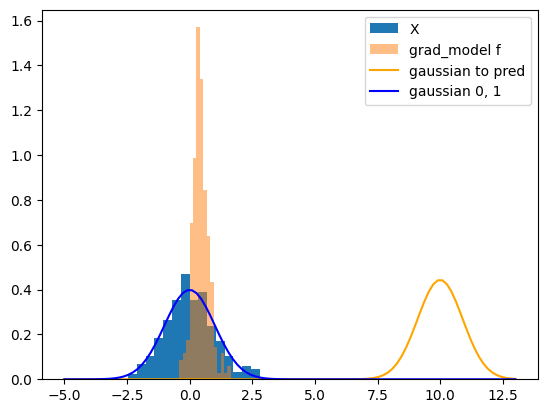

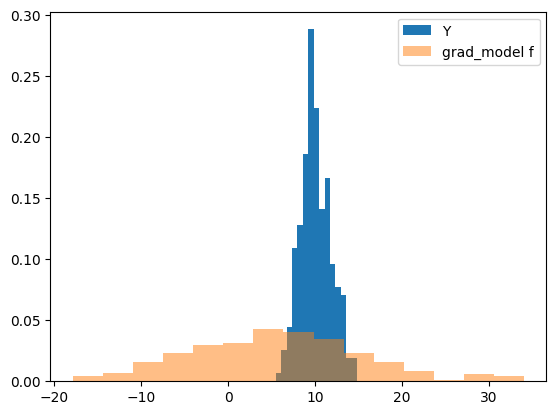

tensor([[0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0000, 1.2996],
        [0.0

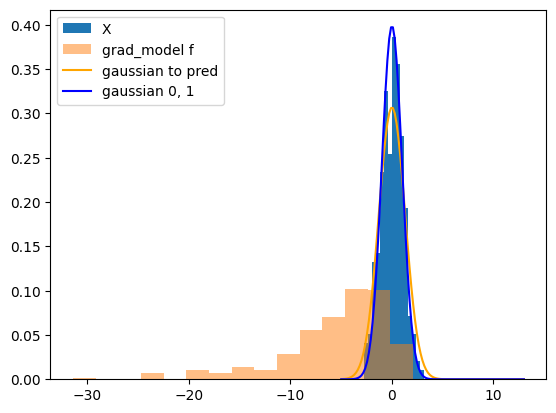

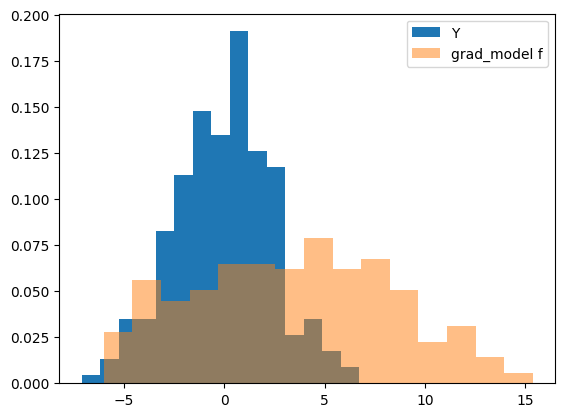

tensor([[1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0000, 0.3815],
        [1.0

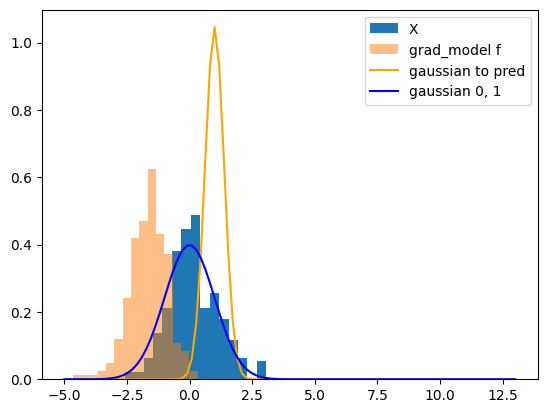

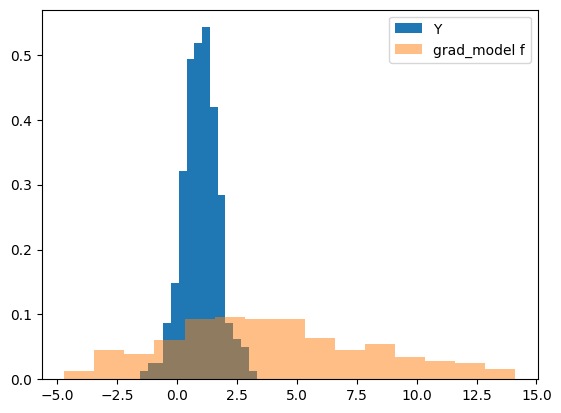

tensor([[5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0000, 3.0683],
        [5.0

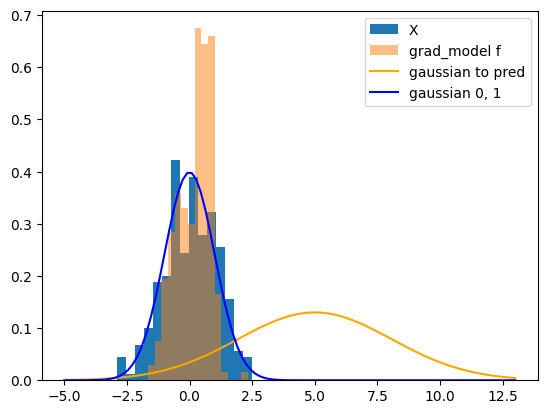

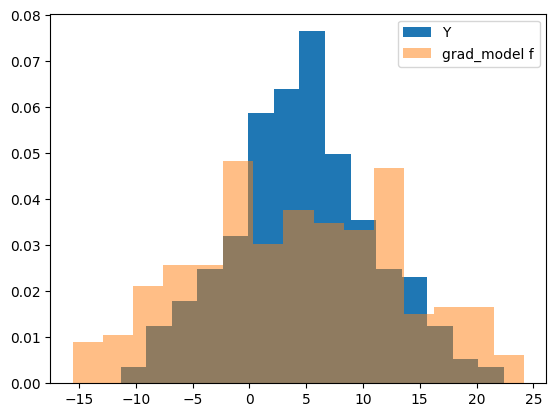

tensor([[0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0000, 0.1664],
        [0.0

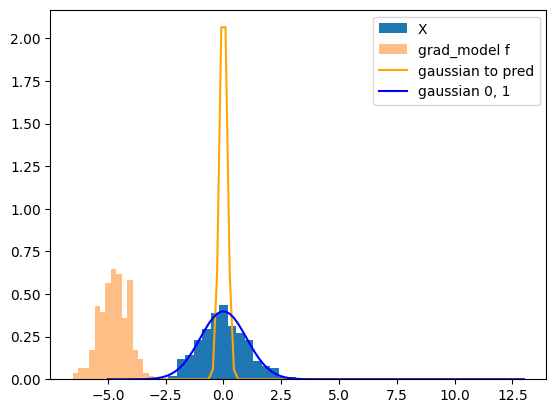

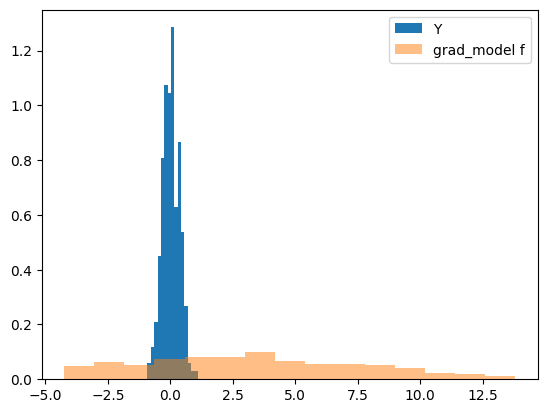

tensor([[-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3.3545],
        [-5.0000,  3

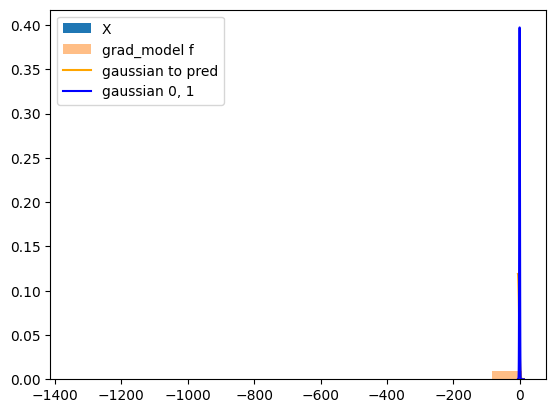

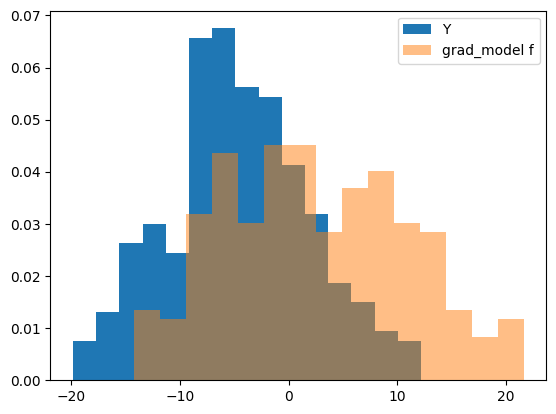

tensor([[9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0000, 4.6227],
        [9.0

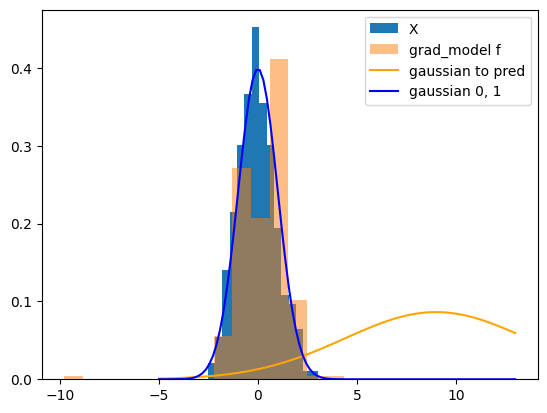

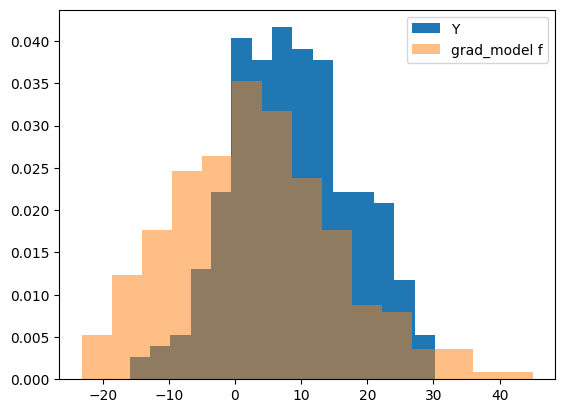

tensor([[10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2.7933],
        [10.0000,  2

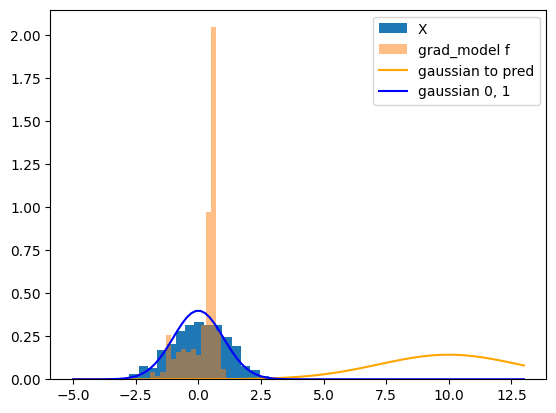

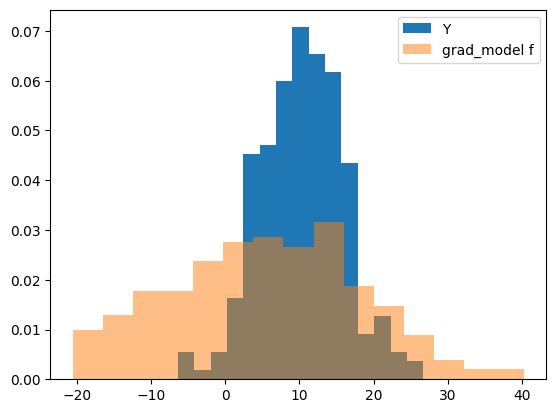

tensor([[6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0000, 3.0566],
        [6.0

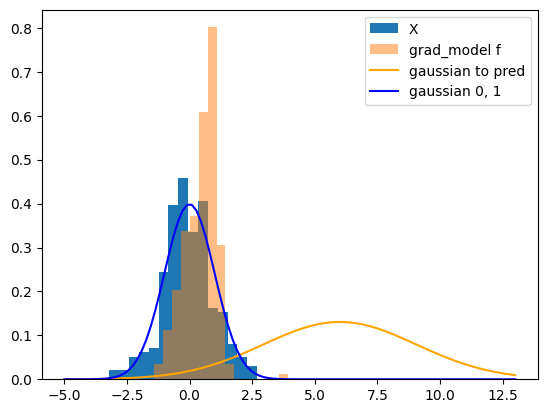

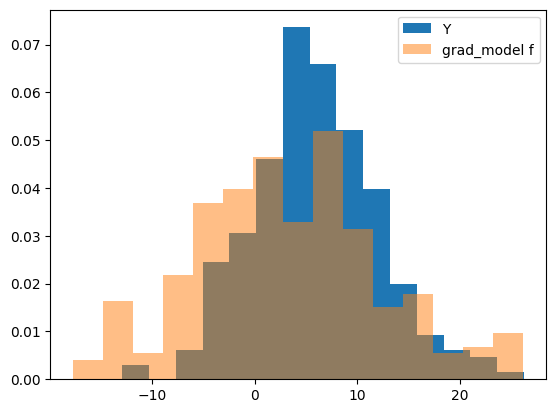

tensor([[-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1.0169],
        [-8.0000,  1

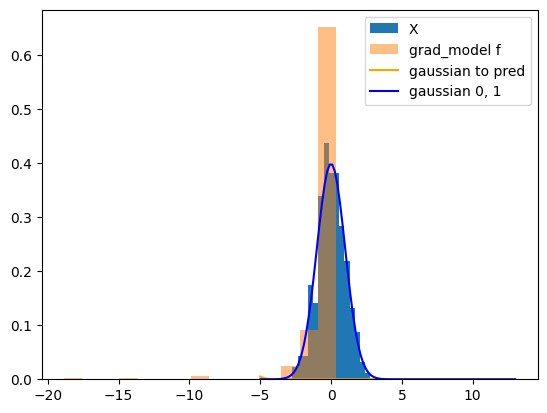

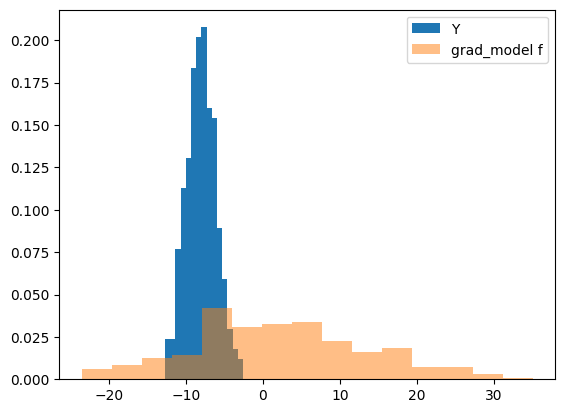

tensor([[2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0000, 0.8576],
        [2.0

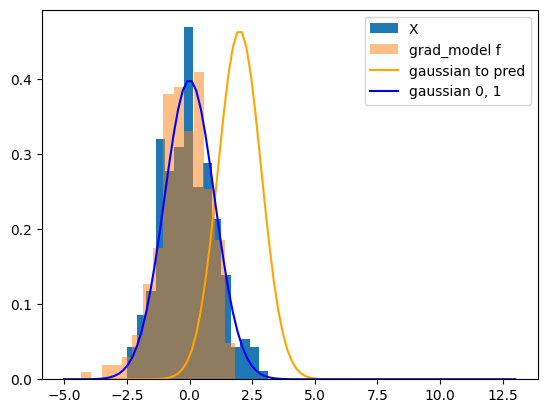

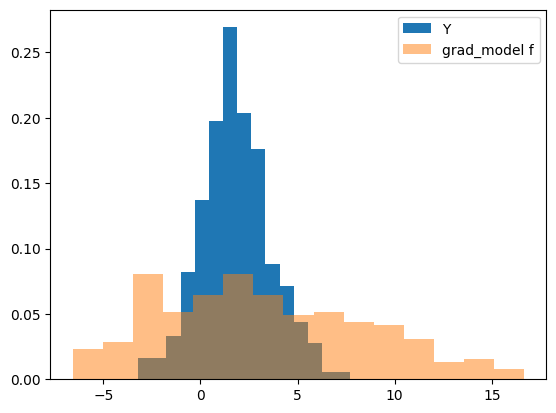

tensor([[9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0000, 3.4126],
        [9.0

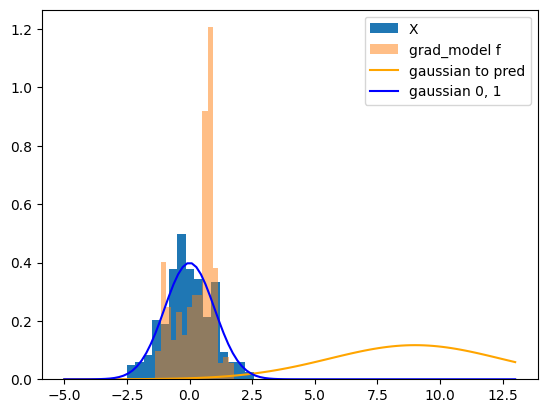

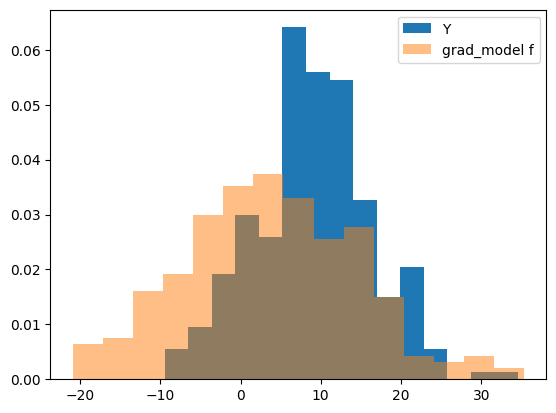

tensor([[-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3.6870],
        [-6.0000,  3

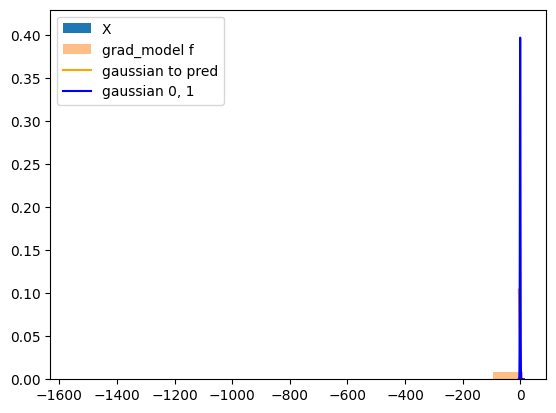

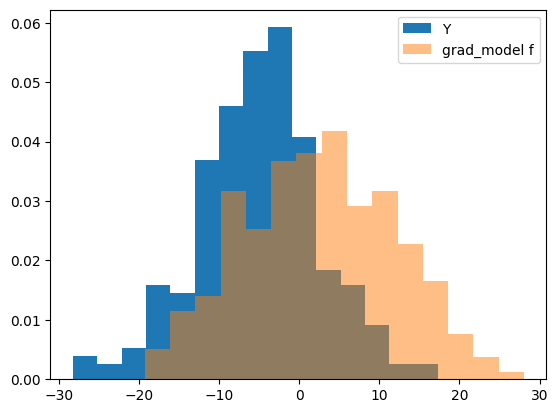

tensor([[-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4.6770],
        [-8.0000,  4

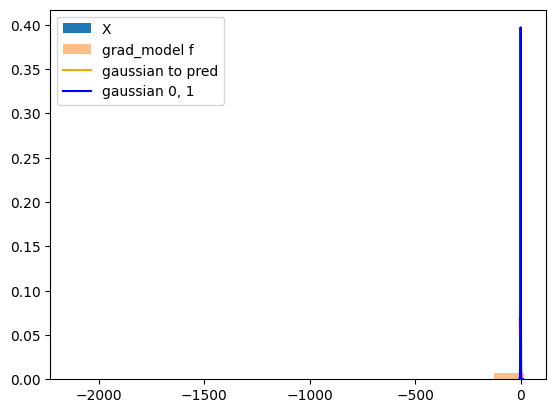

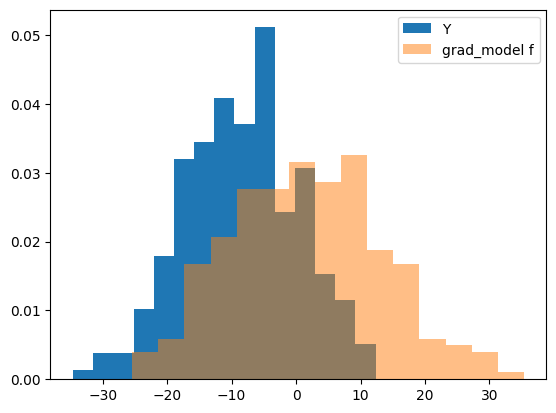

tensor([[-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2.1221],
        [-7.0000,  2

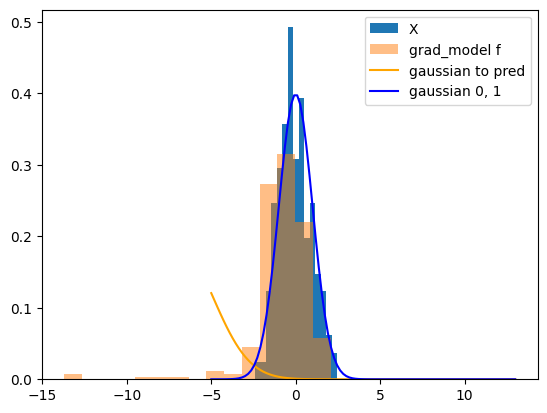

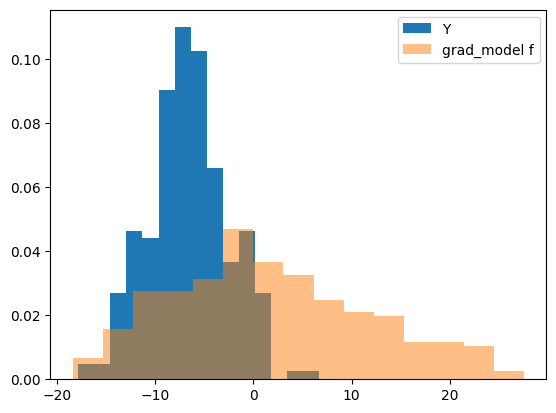

In [78]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C
for test in range(20):
    #Calcul de la dérivée du PICNN
    x_i = X[test, :, :]
    y_i = Y[test, :, :]
    c_i = C[test, :, :]

    print(c_i)

    y_i.requires_grad_(True)
    x_i.requires_grad_(True)
    c_i.requires_grad_(True)    

    output_model_f = ICNNf(x_i, c_i)
    grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

    output_model_g = ICNNg(y_i, c_i)
    grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]


    plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
    plt.hist(grad_model_g[:, 0].detach().numpy(),  bins=15, label = 'grad_model f', density = True, alpha = 0.5)
    plt.plot(values, stats.norm.pdf(values, c_i[0, 0].detach().numpy(), c_i[0, 1].detach().numpy()), label = "gaussian to pred", color = 'orange')
    plt.plot(values, stats.norm.pdf(values, 0,1), label = "gaussian 0, 1", color = 'blue')
    plt.legend()
    plt.show()

    plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
    plt.hist(grad_model_f[:, 0].detach().numpy(),  bins=15, label = 'grad_model f', density = True, alpha = 0.5)
    plt.legend()
    plt.show()